# Notebook with some of the models and tools used in the C2 competition

In this notebook we will show some of the models and tools used in the C2 competition. The notebook is divided in the following sections:
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Models](#Models)
    1. [Data preparation](#Data-preparation)
    2. [Attention](#Attention)
    3. [CNN LSTM](#CNN-LSTM)
3. [Ensemble](#Ensemble)

We do not want to show all the models we used in the competition, but only some of them in order to reduce the code base. The models are not optimized, but they are just an example of what we did. So not in all models in there there is hyperparameter optimization, data augmentation, etc.

In [22]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten, Reshape, Attention

import optuna as opt
from optuna.integration import TFKerasPruningCallback
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# EXPLORATORY DATA ANALYSIS

In [19]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')
print("Training data shape: ", training_data.shape)
print("Valid periods data shape: ", valid_periods.shape)
print("Categories data shape: ", categories.shape)
print("Unique categories: ", np.unique(categories))
print("Example of valid periods: ", valid_periods[1])
print("Sequence lengths: ", valid_periods[:10, 1] - valid_periods[:10, 0])
print("Maximum minimum sequence length: ", (valid_periods[:, 1] - valid_periods[:, 0]).min(), (valid_periods[:, 1] - valid_periods[:, 0]).max())
print("Minimum maximum: ", training_data.min(), training_data.max())

Training data shape:  (48000, 2776)
Valid periods data shape:  (48000, 2)
Categories data shape:  (48000,)
Unique categories:  ['A' 'B' 'C' 'D' 'E' 'F']
Example of valid periods:  [2325 2776]
Sequence lengths:  [451 451 451  64  94 648  94  94 804 348]
Maximum minimum sequence length:  24 2776
Minimum maximum:  0.0 1.0


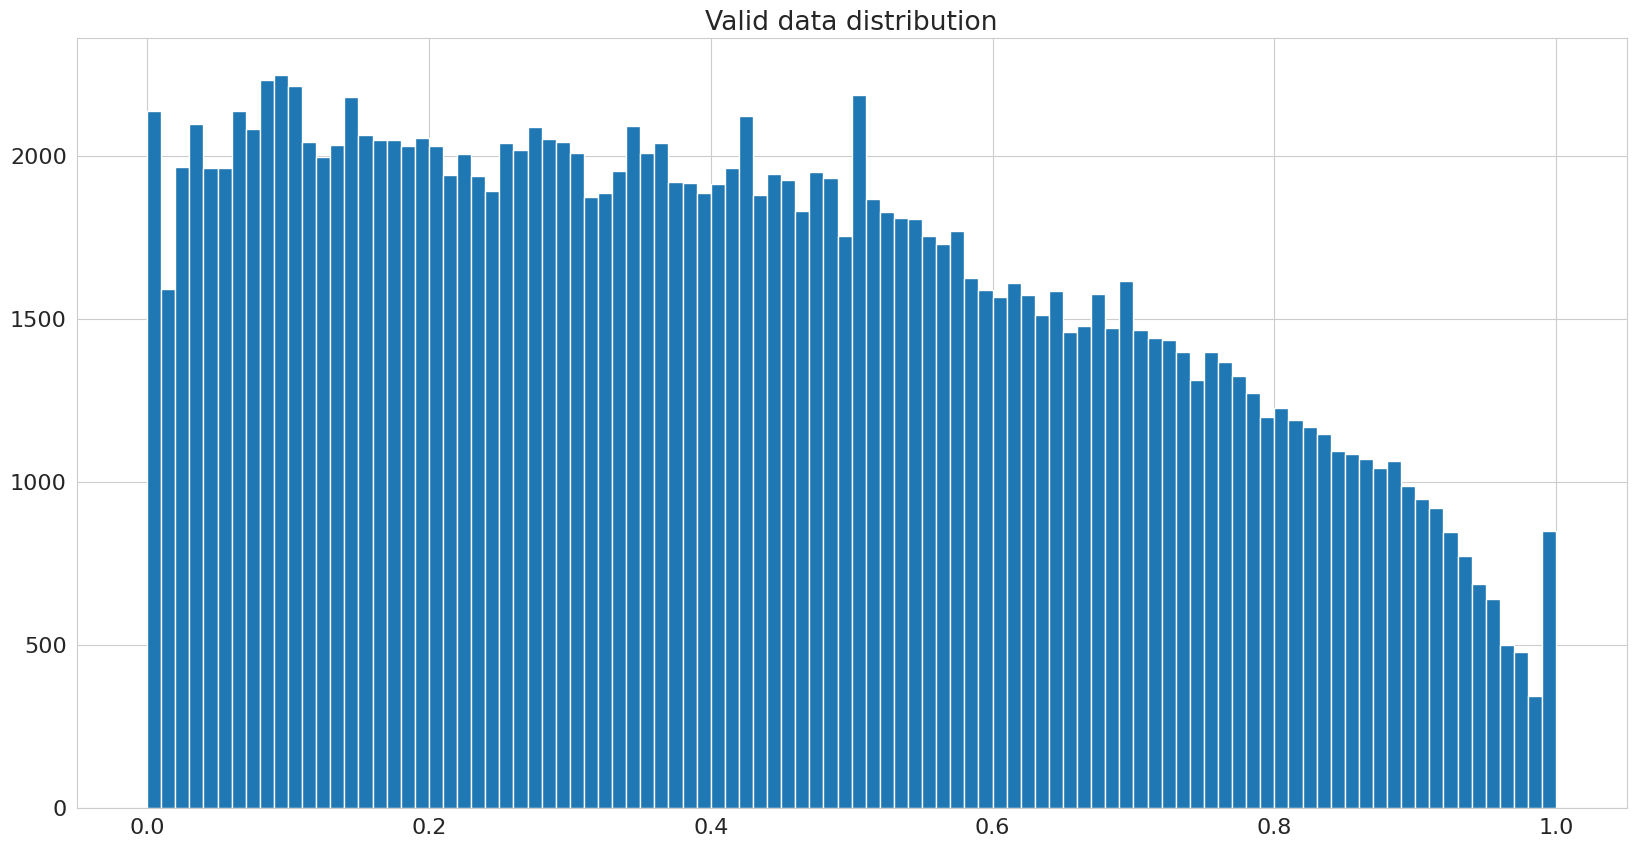

In [4]:
flatten_clean_data = np.array([])
for i in range(800):
    d = np.random.randint(0, training_data.shape[0])
    flatten_clean_data = np.append(flatten_clean_data, training_data[d, valid_periods[d, 0]:valid_periods[d, 1]])
    
# plot valid data distribution
plt.figure(figsize=(20, 10))
plt.hist(flatten_clean_data, bins=100)
plt.title('Valid data distribution')
plt.show()

Text(0.5, 1.0, 'Sequence lengths distribution')

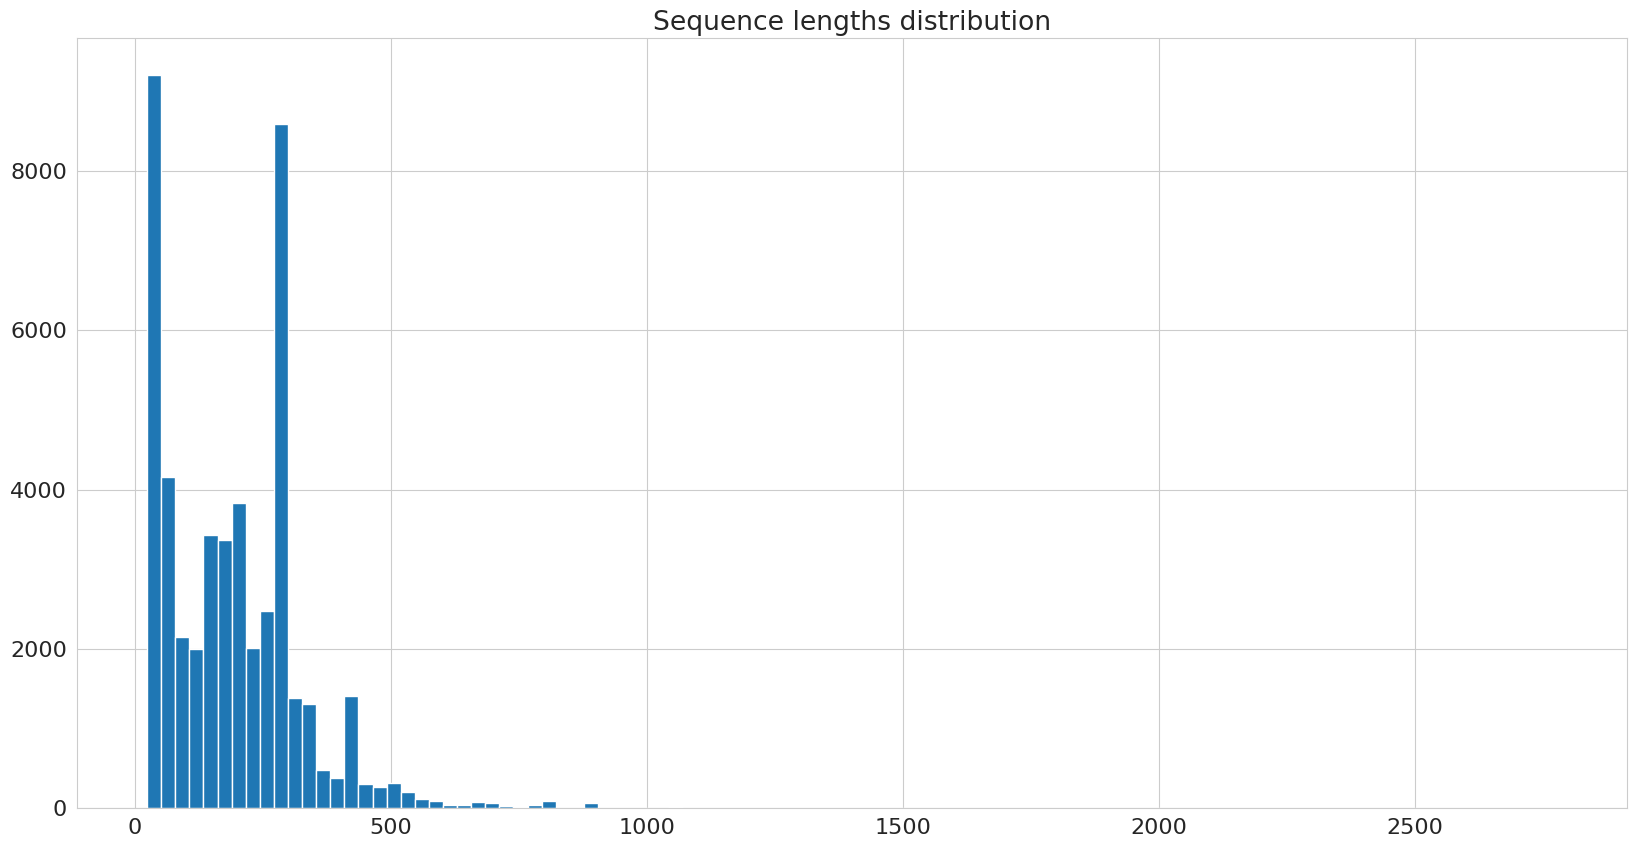

In [5]:
# plot sequence lengths distribution
plt.figure(figsize=(20, 10))
plt.hist(valid_periods[:, 1] - valid_periods[:, 0], bins=100)
plt.title('Sequence lengths distribution')

In [6]:
df = pd.DataFrame(columns=['Category', 'Number of sequences', 'Mean', 'Std', 'Min', 'Max'])
for i in np.unique(categories):
    df = df.append({'Category': i, 
                    'Number of sequences': np.sum(categories == i), 
                    'Mean': np.mean(training_data[categories == i]), 
                    'Std': np.std(training_data[categories == i]), 
                    'Min': np.min(training_data[categories == i]), 
                    'Max': np.max(training_data[categories == i])}, ignore_index=True)
df = df.set_index('Category')
df

,Number of sequences,Mean,Std,Min,Max
Category,,,,,
A,5728,0.046666,0.161872,0.0,1.0
B,10987,0.024237,0.117269,0.0,1.0
C,10017,0.031969,0.134708,0.0,1.0
D,10016,0.032416,0.133929,0.0,1.0
E,10975,0.024706,0.118947,0.0,1.0
F,277,0.028432,0.127809,0.0,1.0


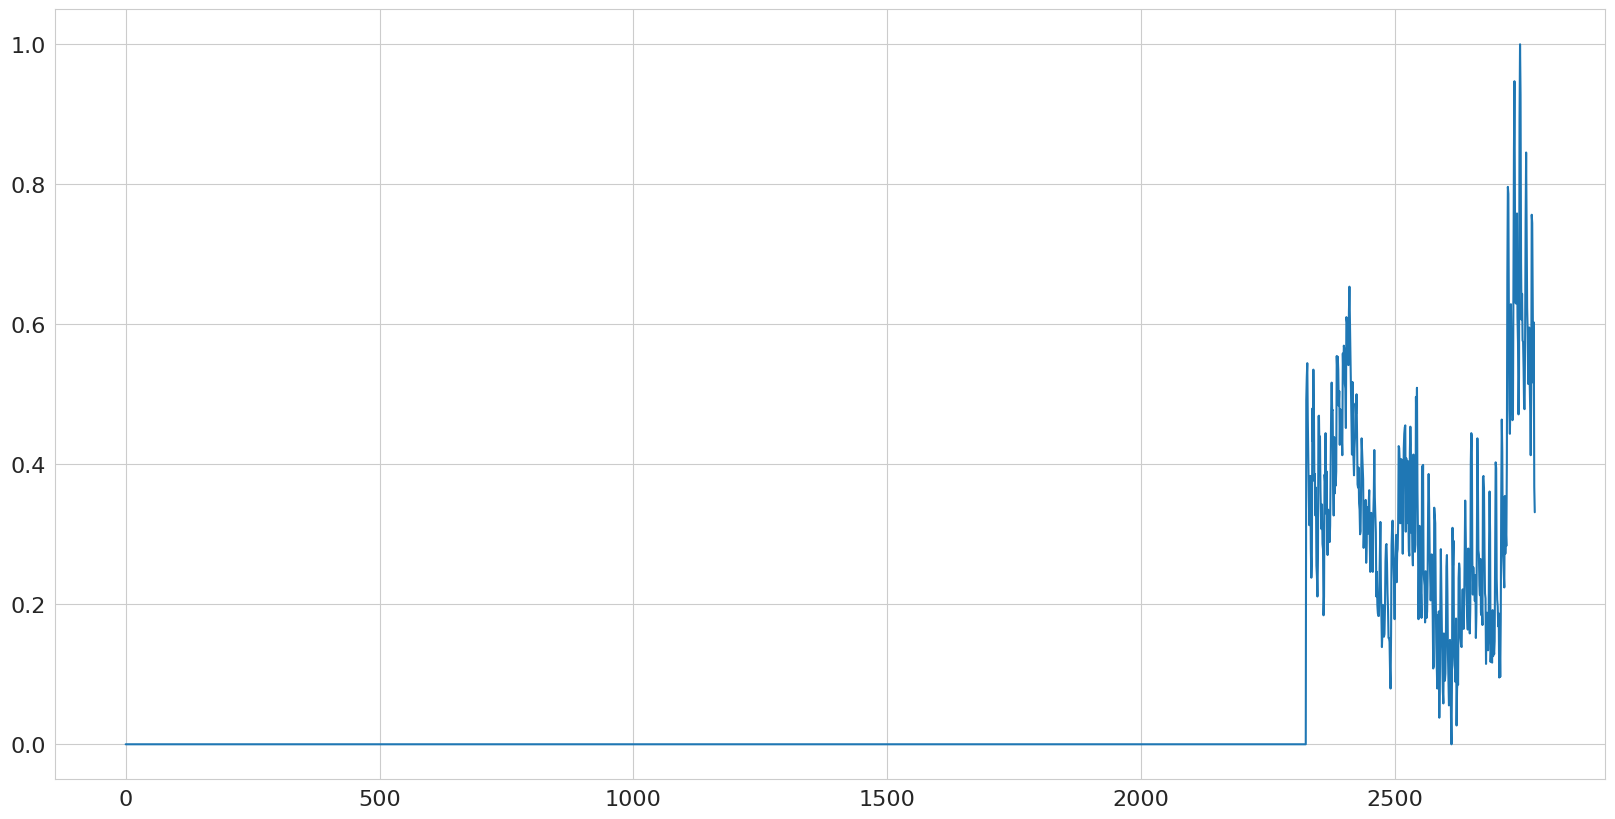

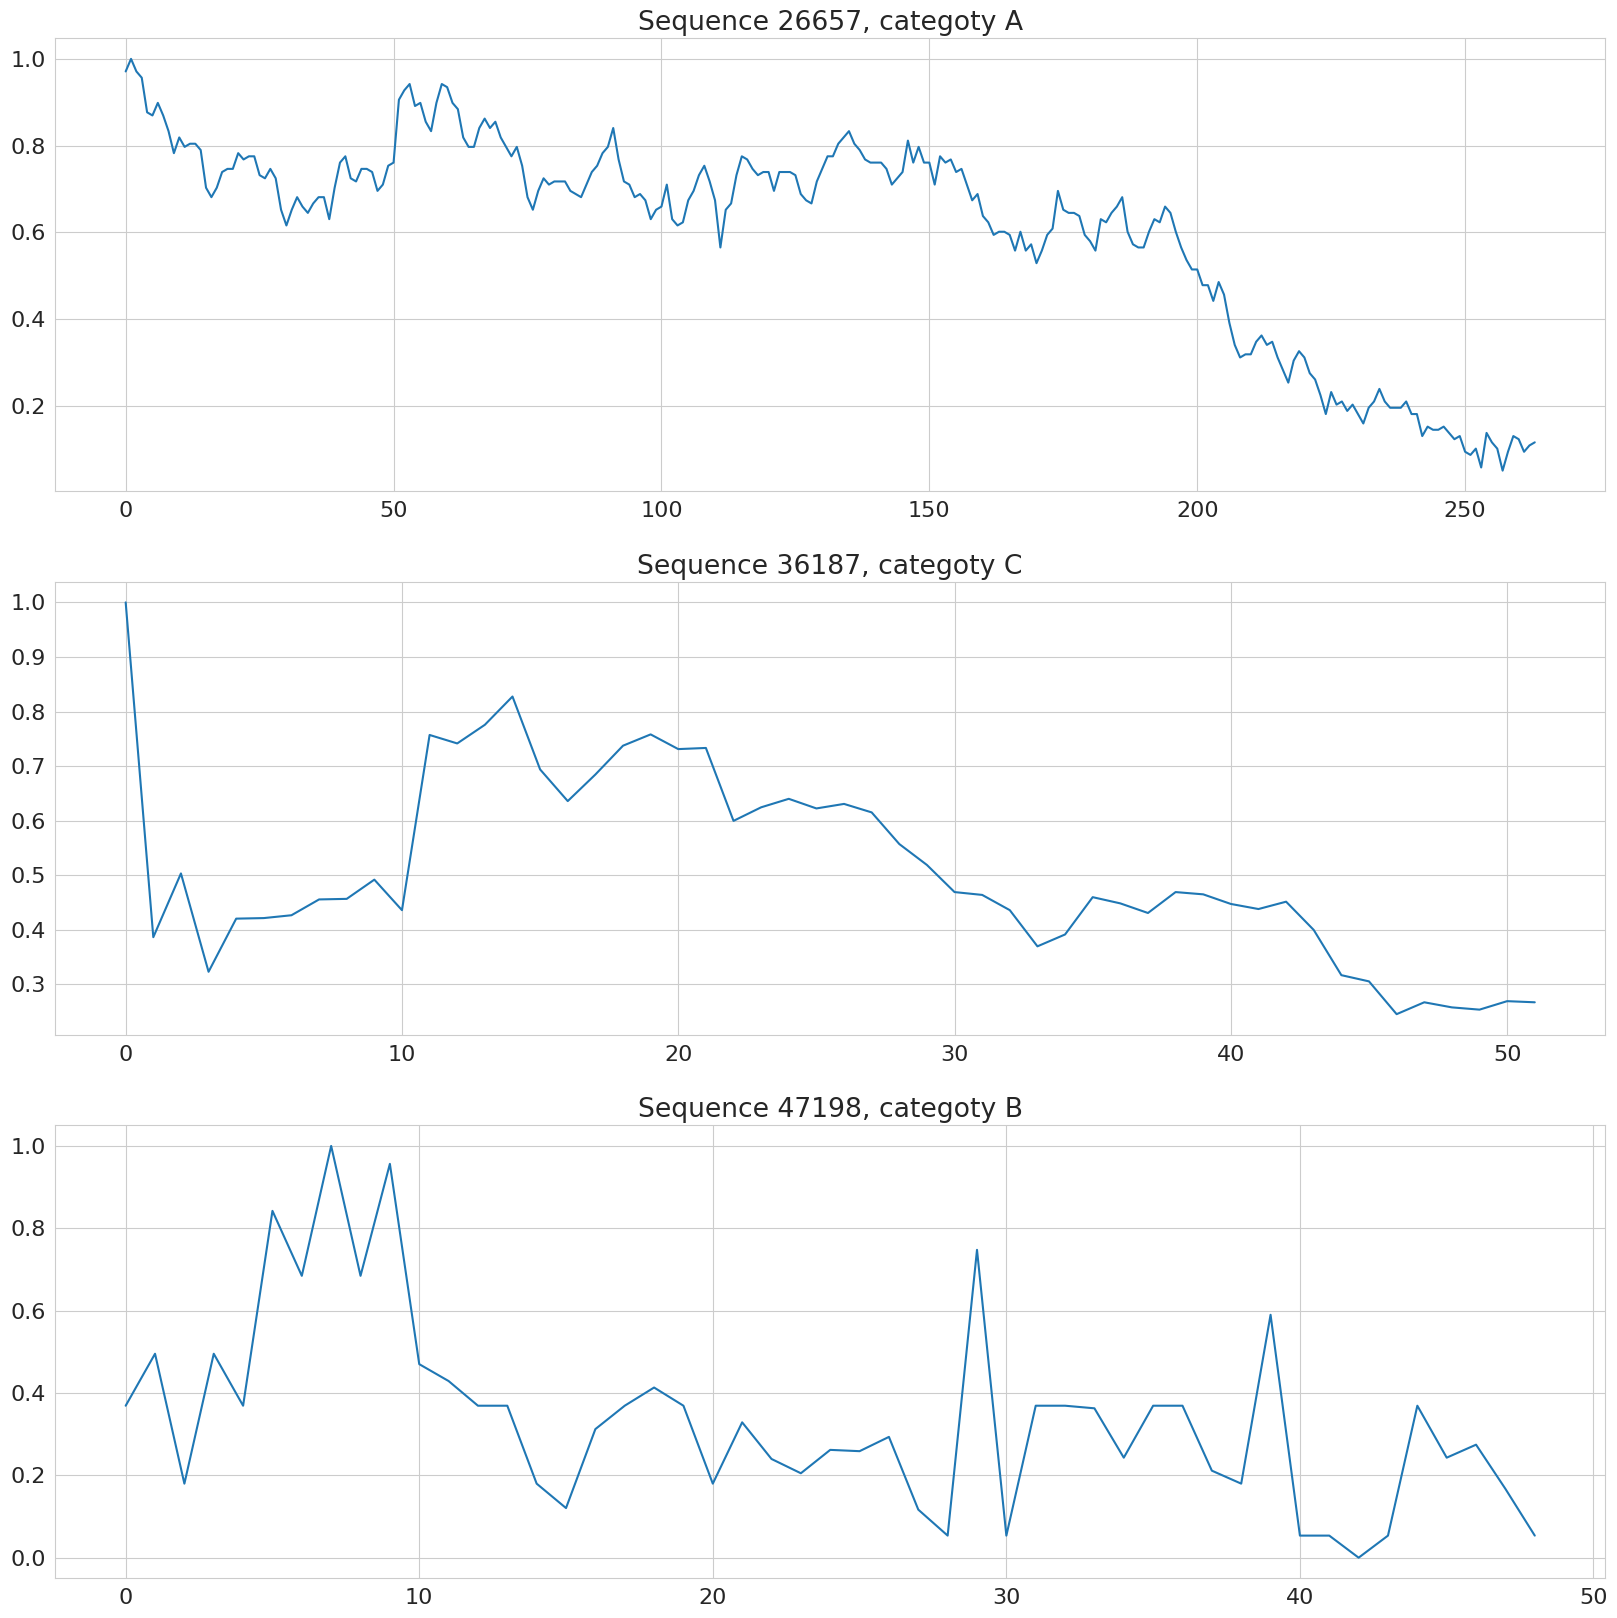

In [7]:
# plot the data
plt.figure(figsize=(20, 10))
plt.plot(training_data[0, :], label='Sequence 0')

n_subplots = 3
plt.figure(figsize=(20, 20))
for i in range(n_subplots):
    d = np.random.randint(0, training_data.shape[0])
    plt.subplot(n_subplots, 1, i+1)
    plt.plot(training_data[d, valid_periods[d, 0]:valid_periods[d, 1]])
    plt.title('Sequence {}, categoty {}'.format(d, categories[d]))

### Outlier check

In [10]:
# from tqdm import tqdm
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import pywt
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications.mobilenet import preprocess_input
# 
# # Assuming 'data' contains your time series data and 'category' contains the corresponding categories
# N = 3000
# # Function to perform wavelet transformation and generate images
# def wavelet_to_image(series):
#     wavelet_type = 'morl'
#     widths = np.arange(1, 64)
#     coeffs, _ = pywt.cwt(series, widths, wavelet_type)
#     return coeffs.T.astype('float32').reshape(200,63)  # Transpose and convert to float32
# 
# # Prepare wavelet images for each time series in data tqdm
# wavelet_images = []
# for series in tqdm(training_data[:N]):
#     wavelet_images.append(wavelet_to_image(series))
# 
# # Reshape images to match MobileNet input shape
# reshaped_images = np.array(wavelet_images).reshape(-1, wavelet_images[0].shape[0], wavelet_images[0].shape[1], 1)
# 
# # Replicate single-channel images to create a 3-channel input
# processed_images = np.concatenate([reshaped_images] * 3, axis=-1)
# 
# # Preprocess images for MobileNet
# processed_images = preprocess_input(processed_images)
# 
# # Load MobileNet model with pre-trained weights (imagenet)
# mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(reshaped_images.shape[1], reshaped_images.shape[2], 3))
# 
# # Extract features using MobileNet
# features = mobilenet_model.predict(processed_images)
# 
# # Reshape features to 1D array
# features = features.reshape(features.shape[0], -1)
# 
# # Perform t-SNE embedding on the extracted features
# tsne = TSNE(n_components=2, random_state=42)
# embedded_features = tsne.fit_transform(features)
# 
# # Create a dictionary to map categories to colors
# category_color_map = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'orange', 'E': 'purple', 'F': 'brown'}
# 
# # Plot the t-SNE embeddings with colors based on categories
# plt.figure(figsize=(8, 6))
# for cat in np.unique(categories[:N]):
#     indices = categories[:N] == cat
#     plt.scatter(embedded_features[indices, 0], embedded_features[indices, 1], c=category_color_map[cat],
#                 label=f'Category {cat}')
# 
# plt.title('t-SNE Plot of MobileNet Features from Wavelet Transformed Data')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend()
# plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 174888 into shape (200,63)

# MODELS

## DATA PREPARATION

In [20]:
from C2.notebooks.Utils import split_dataset, build_sequences_optimized
from C2.notebooks.data_augmentation import augment_data
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categories.reshape(-1, 1))
categories = enc.transform(categories.reshape(-1, 1)).toarray()

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_validation_data, train_validation_labels, test_data, test_labels, train_validation_categories, test_categorie = split_dataset(dataset, labels, categories)

train_data, train_labels, validation_data, validation_labels, train_categories, validation_categories = split_dataset(train_validation_data, train_validation_labels, train_validation_categories, augment_train_data=False, num_augmentations=3)

train_data_augmented, train_labels_augmented, train_categories_augmented = augment_data(train_data, train_labels, train_categories, num_augmentations=3)

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
validation_data = validation_data.reshape((validation_data.shape[0], validation_data.shape[1], 1))
validation_labels = validation_labels.reshape((validation_labels.shape[0], validation_labels.shape[1], 1))

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]

Dataset shape:  (48000, 200)
Train data shape:  (38400, 200)
Test data shape:  (9600, 200)
Train data shape:  (30720, 200)
Test data shape:  (7680, 200)
Augmentation round: 0
Augmentation round: 1
Augmentation round: 2


### Attention

In [ ]:
def build_LSTM_ENC_DEC_model_attention(input_shape, output_shape, learning_rate=0.001, num_layers=2, num_units_lstm=32, num_units_final_dense = 128, dropout=0.2):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    # LSTM layers
    x = input_layer
    for _ in range(num_layers):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units_lstm, name='lstm', return_sequences=True))(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        
    Attention()
    lstm_attention = tf.keras.layers.Flatten()(Attention()([x,x]))
    flatten_input = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Flatten()(x)

    # Skipper layer
    x = tf.keras.layers.Concatenate()([x, flatten_input, lstm_attention])
    x = tf.keras.layers.Dense(num_units_final_dense, activation='relu')(x)
    # Output layer
    output_layer = tf.keras.layers.Dense(output_shape[0], name='output_layer', activation='sigmoid')(x)
    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='Better_CONV_LSTM_model')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

def objective(trial):
    # Clear clutter from previous session graphs.
    tf.keras.backend.clear_session()
   
    trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    trial.suggest_int("num_layers", 1, 1)
    trial.suggest_int("num_units_lstm", 16, 64, log=True)
    trial.suggest_int("num_units_final_dense", 16, 128, log=True)
    trial.suggest_float("dropout", 0.0, 0.5)
    # Create the Transformer model
    model = build_LSTM_ENC_DEC_model_attention(input_shape, output_shape, **trial.params)
    

    
    batch_size = 256
    epochs = 30
    # Train the model.
    model.fit(
        x = train_data.reshape(-1, input_shape[0], input_shape[1]),
        y = train_labels,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(validation_data.reshape(-1, input_shape[0], input_shape[1]), validation_labels),
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5),
            TFKerasPruningCallback(trial, "val_loss"),
        ]
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(validation_data.reshape(-1, input_shape[0], input_shape[1]), validation_labels, verbose=0)
    return score[0]

# create a study object and optimize the objective function.
study = opt.create_study(direction="minimize", pruner=MedianPruner(n_warmup_steps=1), sampler=TPESampler(seed=seed), study_name='attention', storage='sqlite:///optuna.db', load_if_exists=True)
study.optimize(objective, n_trials=100)

### CNN LSTM

In [24]:
def build_LSTM_CNN_params(input_shape, output_shape, learning_rate=0.001, num_layers=2, num_units_lstm=32, num_units_final_dense = 128, dropout=0.2):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    # input_category = tf.keras.layers.Input(shape=(1,), name='input_category')
    # subtract last input value of the input sequence to all the input sequence, do like input_layer - constant, where constant is the last value of the input_layer
    
    last_seq = tf.keras.layers.Lambda(lambda x: x[:, -1:, :])(input_layer)
    x = input_layer - last_seq
    
    
    
        
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(conv)
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(conv)
    x = conv
    
    # LSTM layers
    for _ in range(num_layers):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(num_units_lstm/4), name='lstm', return_sequences=True))(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        
    x = tf.keras.layers.Flatten()(x)
    flatten_input = tf.keras.layers.Flatten()(input_layer)
    # Skipper layer
    x = tf.keras.layers.Concatenate()([x, flatten_input])
    x = tf.keras.layers.Dense(num_units_final_dense, activation='relu')(x)
    
    # Output layer
    output_layer = tf.keras.layers.Dense(output_shape[0], name='output_layer', activation='linear')(x)
    
    # sum last output last_seq to all the output sequence, do like output_layer + constant, where constant is the last value of the last_seq
    
    # https://arxiv.org/pdf/2308.11200v1.pdf
    output_layer = output_layer +  tf.keras.layers.Reshape((1,))(last_seq)
    
   
    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='Better_CONV_LSTM_model')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

In [25]:
batch_size = 256
epochs = 11

model = build_LSTM_CNN_params(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True) 

model.fit(
    x = train_validation_data,
    y = train_validation_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(test_data, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)
    ]
)

Model: "Better_CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1, 1)                 0         ['input_layer[0][0]']         
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 200, 1)               0         ['input_layer[0][0]',         
 da)                                                                 'lambda[0][0]']              
                                                                                                  
 conv1d (Conv1D)             (None, 200, 32)              128       ['tf.math

32/32 [==============================] - 2s 14ms/step


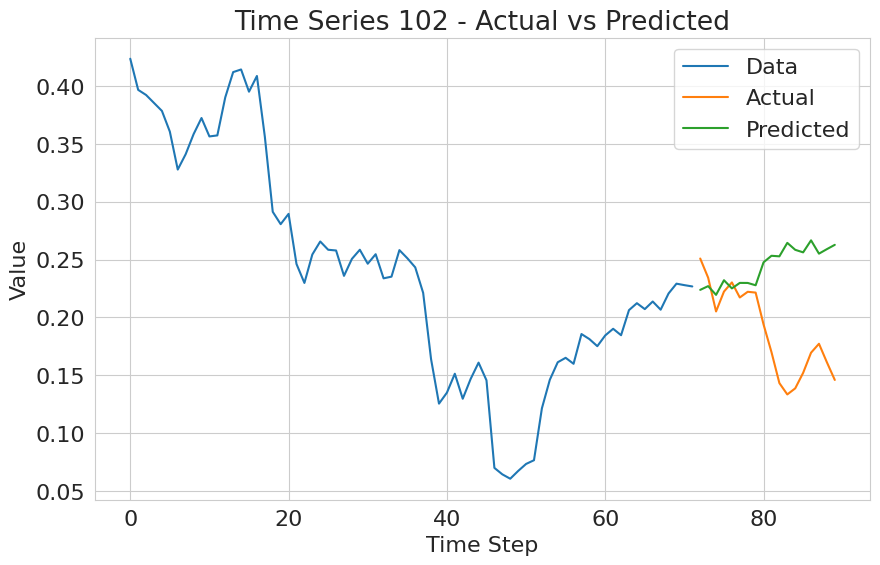

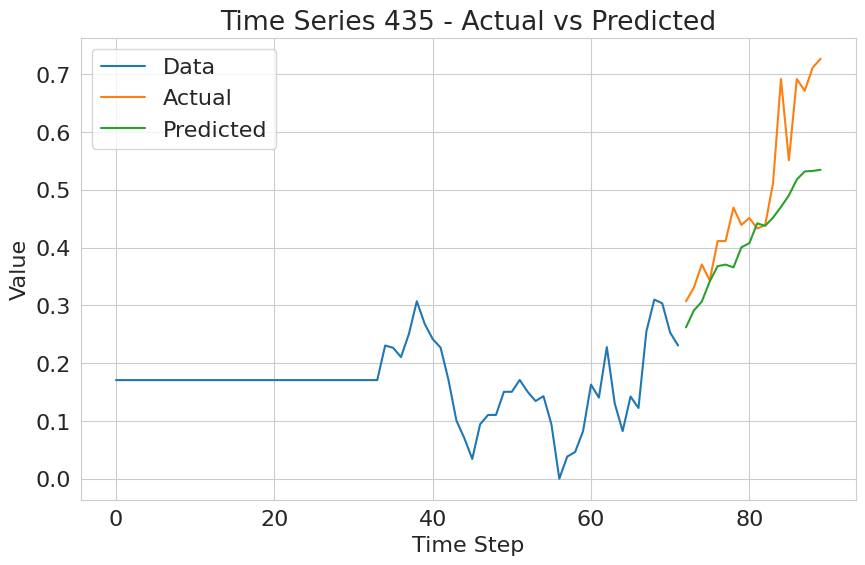

In [26]:
import Utils
l = 1000
valid_data_predictions = model.predict(train_data[:l])
for _ in range(2):
    idx = np.random.randint(0, l)
    Utils.plot_predictions(train_data, valid_data_predictions, train_labels, idx)

# Encoder Decoder with skip connections

Model: "Better_CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 128)                  33792     ['input_layer[0][0]']         
 onal)                                                                                            
                                                                                                  
 dropout_3 (Dropout)         (None, 128)                  0         ['bidirectional_3[0][0]']     
                                                                                                  
 repeat_vector (RepeatVecto  (None, 18, 128)              0         ['dropout

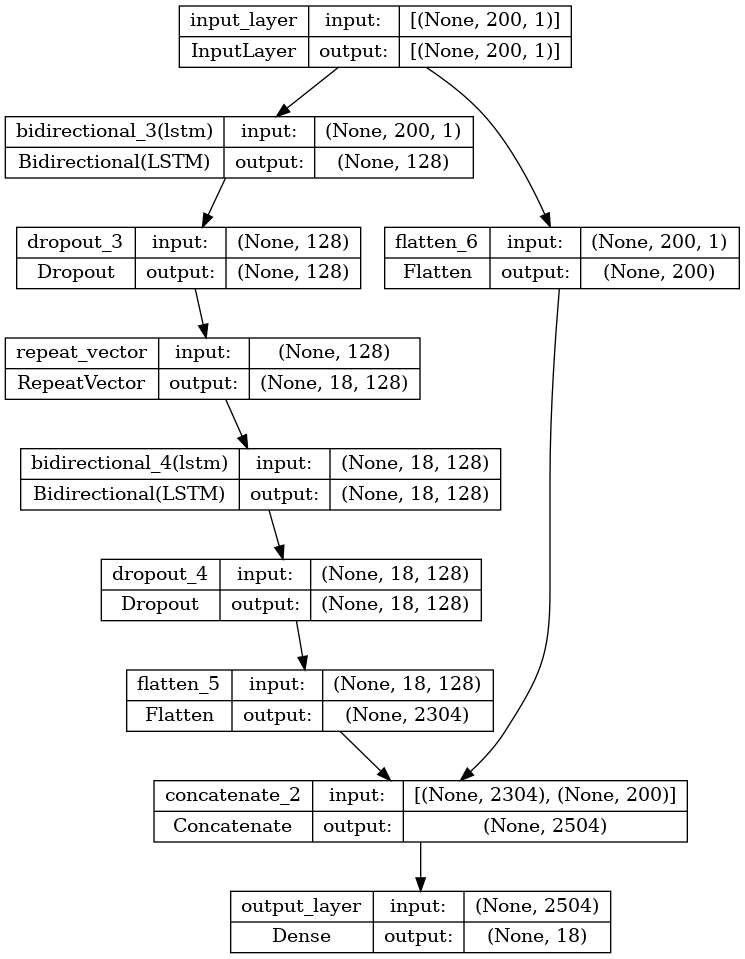

In [27]:
def build_LSTM_ENC_DEC_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    # LSTM layers
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm'))(input_layer)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.RepeatVector(output_shape[0])(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm', return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    flatten_input = tf.keras.layers.Flatten()(input_layer)
    # Skipper layer
    x = tf.keras.layers.Concatenate()([x, flatten_input])
    # Output layer
    output_layer = tf.keras.layers.Dense(output_shape[0], name='output_layer', activation='sigmoid')(x)
    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='Better_CONV_LSTM_model')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

batch_size = 256
epochs = 20

model = build_LSTM_ENC_DEC_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True) 

# ENSEMBLE

In [29]:
models = [file_name for file_name in os.listdir('../ensemble_models/models')]
models

['0052_ENC_DEC_FF_model.h5',
 '0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5',
 '0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164',
 '0065_resnet_5blocks_20epochs.h5',
 'lstm_model_step9.h5',
 '0073_resnet_3blocks.h5',
 '0055_CNN_LSTM_109_0253',
 'LSTM_best_18.h5',
 '0060mix_conv_lstm_conv_11_0255']

In [ ]:
import sklearn
import pandas as pd
dataframe = pd.DataFrame()

predictions_all = np.zeros((labels.shape[0], labels.shape[1], len(models)*4))

for i, model_name in enumerate(models):
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    if "cat" in model_name.lower():
        preds = model.predict([dataset, categories], batch_size=512*2)
        predictions_all[:, :, i] = preds
    elif "step9" in model_name.lower():
        preds1 = model.predict(dataset, batch_size=512*2)
        expanded_dataset = np.concatenate((dataset, preds1), axis=1)
        expanded_dataset = expanded_dataset[:, -200:]
        preds2 = model.predict(expanded_dataset, batch_size=512*2)
        preds = np.concatenate((preds1, preds2), axis=1)

        predictions_all[:, :, i] = preds
    else:
        preds = model.predict(dataset, batch_size=512*2)
        predictions_all[:, :, i] = preds

    predictions_all[:, :, i] = preds
    panads_entry = {}
    panads_entry['model_name'] = model_name
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)

# autoregressive
window = 3
prediction_len = 18
assert prediction_len % window == 0

for i, model_name in enumerate(models):
    j = len(models) + i
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    expanded_dataset = dataset
    if "cat" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict([expanded_dataset, categories], batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    elif "step9" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-9+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    else:
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds

    panads_entry = {}
    panads_entry['model_name'] = model_name + "_autoregressive" + str(window)
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)


window = 6

for i, model_name in enumerate(models):
    j = len(models)*2 + i
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    expanded_dataset = dataset
    if "cat" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict([expanded_dataset, categories], batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    elif "step9" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-9+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    else:
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds

    panads_entry = {}
    panads_entry['model_name'] = model_name + "_autoregressive" + str(window)
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)

window = 9
for i, model_name in enumerate(models):
    j = len(models)*3 + i
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    expanded_dataset = dataset
    if "cat" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict([expanded_dataset, categories], batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    elif "step9" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            print(expanded_dataset.shape)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            print(expanded_dataset.shape)
            expanded_dataset = expanded_dataset[:, -200:]
            print(expanded_dataset.shape)
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    else:
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
        
    panads_entry = {}
    panads_entry['model_name'] = model_name + "_autoregressive" + str(window)
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)

In [ ]:
# ENSEMBLE MODEL average
predictions = np.mean(predictions_all, axis=2)